In [1]:
## Updated 1-7-25

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import random
import unsupervised_scripts
import processing
from tqdm import tqdm

def create_background(array, data):
    background = data.create_background('water_HSI_76.csv')

    background = np.tile(background, (array.shape[1], 1)).T
    background = processing.normalize(background, array[-1,:], np.median(array[:data.ch_start,:], axis=0),axis=0)

    corrected_spectra = spectra.T-background
    return corrected_spectra

data = processing.load_data()
spectra, img_dict = data.load_spectra()
corrected_spectra = create_background(spectra, data)
image_vec = corrected_spectra
save_input = unsupervised_scripts.save_input()

sample_list = os.listdir(data.data_dir)
max_img_list = []
for idx, image_name in tqdm(enumerate(sample_list)):
    if not image_name.endswith('.tif') or image_name.startswith('.'):
        continue

    image = io.imread(os.path.join(data.data_dir+os.sep+image_name))
    max_img = np.max(image,axis=0)
    max_img_list.append(max_img)



2025-05-29 17:02:47.616 python[5450:234815] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'
2it [00:02,  1.36s/it]

Spectra size is: (61, 4410450)


3it [00:05,  1.90s/it]

Spectra size is: (61, 6615675)


4it [00:08,  2.15s/it]

Spectra size is: (61, 8820900)



8it [00:01,  5.93it/s]


In [2]:
img_dict

{'1.1-3782-AKI.tif': {'shape': (61, 1485, 1485)},
 '1.2-3782-AKI.tif': {'shape': (61, 1485, 1485)},
 '1.3-3782-AKI.tif': {'shape': (61, 1485, 1485)},
 '1.4-3782-AKI.tif': {'shape': (61, 1485, 1485)}}

Text(0, 0.5, 'Normalized Intensity (A.U.)')

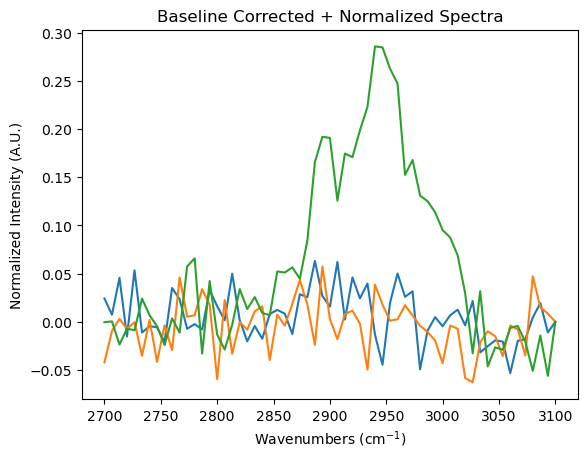

In [3]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
indeces = [random.randint(0,image_vec.shape[0]-1), random.randint(0,image_vec.shape[0]-1), random.randint(0,image_vec.shape[0]-1)]
plt.plot(wavenumbers, image_vec[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [4]:
## Optimizing Silhouette Score (OPTIONAL)
kmeans_vec = unsupervised_scripts.K_means_cluster(image_vec[np.random.randint(image_vec.shape[0],size=50000)])
cluster_range = int(input('Enter range of clusters to optimize: '))
kmeans_vec.kmeans_silhoutette_score(cluster_range+1)

__________________________________________________________________________________
init		time	inertia	silhouette
Clusters: 2
PCA-based K-means	0.245s	5805	0.423
Clusters: 3
PCA-based K-means	0.264s	4576	0.306
Clusters: 4
PCA-based K-means	0.152s	3895	0.269
Clusters: 5
PCA-based K-means	0.127s	3615	0.181
Clusters: 6
PCA-based K-means	0.221s	3393	0.191
Clusters: 7
PCA-based K-means	0.240s	3385	0.180
Clusters: 8
PCA-based K-means	0.257s	3263	0.151
Clusters: 9
PCA-based K-means	0.357s	3145	0.157
Clusters: 10
PCA-based K-means	0.306s	3080	0.119
__________________________________________________________________________________


In [5]:
## Selection of k-means number (default=7)
kmeans_vec = unsupervised_scripts.K_means_cluster(image_vec)
k=int(input('Enter number of k-means centers (Default=7):').strip() or '7')
kmeans_1 = kmeans_vec.kmeans(k)

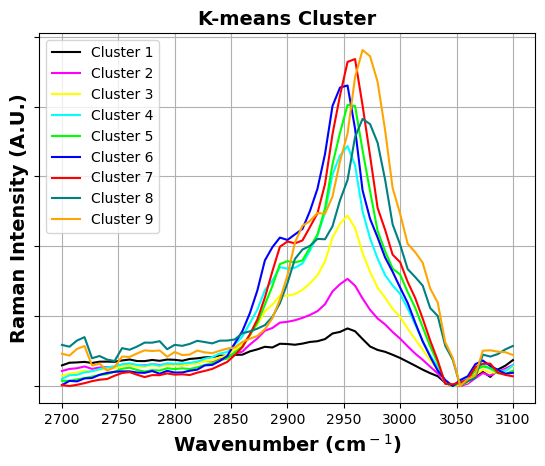

In [6]:
graph_list = ['#000000', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k, dtype='object')
color_list[0] = '#000000'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or graph_list[i])

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
centers = kmeans_vec.kmeans_graph(kmeans_1, wavenumbers, save_input, color_list, save_dir=data.save_dir+os.sep+str(k)+'_Clusters-')

9it [00:00, 27.61it/s]
9it [00:00, 26.94it/s]
9it [00:00, 27.96it/s]
9it [00:00, 27.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


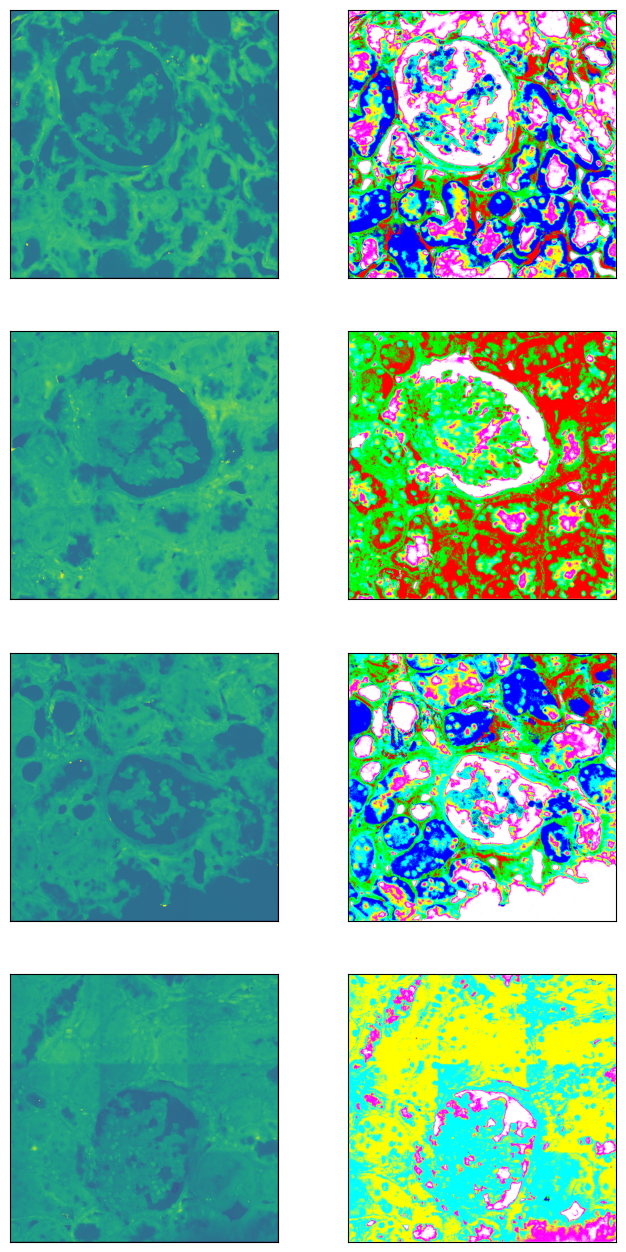

In [7]:
## Visualize Clustered Image
fig_list = ['#FFFFFF', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k, dtype='object')
color_list[0] = '#FFFFFF'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or fig_list[i])
label_idx = kmeans_vec.kmeans_image(kmeans_1, max_img_list, img_dict, save_input, color_list, save_dir=data.save_dir+os.sep+str(k)+'_Clusters-')


In [9]:
## Normalize Spectra
image_norm = np.zeros_like(image_vec)
max_values = np.max(image_vec[label_idx!=0],axis=1)
min_values = np.median(image_vec[label_idx!=0,:data.ch_start], axis=1)
image_norm[label_idx!=0] = processing.normalizebyvalue(image_vec[label_idx!=0], max_val=max_values, min_val=min_values, axis=1)


Text(0, 0.5, 'Normalized Intensity (A.U.)')

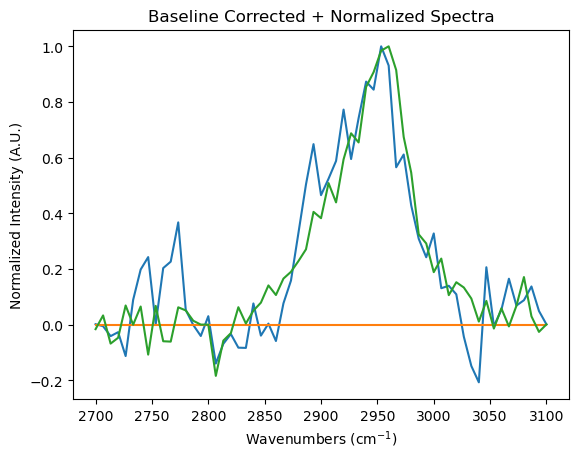

In [10]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [11]:
## Optimizing Silhouette Score (OPTIONAL)
kmeans_norm = unsupervised_scripts.K_means_cluster(image_norm[np.random.randint(image_norm.shape[0],size=50000)])
cluster_range = int(input('Enter range of clusters to optimize: '))
kmeans_norm.kmeans_silhoutette_score(cluster_range+1)

__________________________________________________________________________________
init		time	inertia	silhouette
Clusters: 2
PCA-based K-means	0.024s	34032	0.647
Clusters: 3
PCA-based K-means	0.074s	31697	0.414
Clusters: 4
PCA-based K-means	0.123s	30592	0.305
Clusters: 5
PCA-based K-means	0.235s	29880	0.242
Clusters: 6
PCA-based K-means	0.200s	29395	0.273
Clusters: 7
PCA-based K-means	0.280s	29060	0.256
Clusters: 8
PCA-based K-means	0.272s	29051	0.309
Clusters: 9
PCA-based K-means	0.274s	29021	0.273
Clusters: 10
PCA-based K-means	0.273s	28705	0.238
__________________________________________________________________________________


In [12]:
## Selection of k-means number (default=7)
kmeans_norm = unsupervised_scripts.K_means_cluster(image_norm)
k_norm=int(input('Enter number of k-means centers (Default=7):').strip() or '7')
kmeans_2 = kmeans_norm.kmeans(k_norm)

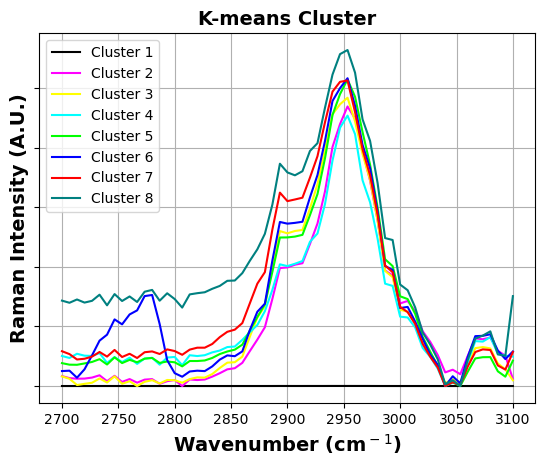

In [13]:
## Visualize Graph of Cluster Centers
graph_list = ['#000000', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k_norm, dtype='object')
color_list[0] = '#000000'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or graph_list[i])

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
_ = kmeans_norm.kmeans_graph(kmeans_2, wavenumbers, save_input, color_list, save_dir=data.save_dir+os.sep+'normalized-'+str(k_norm)+'_Clusters-')

In [14]:
## Visualize Clustered Normalized Spectra
fig_list = ['#FFFFFF', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k_norm, dtype='object')
color_list[0] = '#FFFFFF'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or fig_list[i])
kmeans_norm.kmeans_image(kmeans_2, max_img_list, img_dict,  save_input, fig_list, save_dir=data.save_dir+os.sep+'normalized-'+str(k_norm)+'_Clusters-')

8it [00:00, 189.82it/s]


IndexError: index 8 is out of bounds for axis 0 with size 8